In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import pickle
import io
gin.enter_interactive_mode()
from causal_util import load_env
from sparse_causal_model_learner_rl.loss.losses import fit_loss
from sparse_causal_model_learner_rl.loss.causal_discriminator import siamese_feature_discriminator_l2

from sparse_causal_model_learner_rl.metrics.context_rewrite import context_rewriter
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices
from sparse_causal_model_learner_rl.config import Config
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL

In [2]:
load_config_files(['../sparse_causal_model_learner_rl/configs/rec_nonlin_gnn_gumbel_siamese_l2.gin',
                   '../sparse_causal_model_learner_rl/configs/kc_dec.gin',
                   '../keychest/config/5x5_1f1c1k_obs.gin'])

['rec_nonlin_gnn_gumbel_siamese_l2', 'kc_dec', '5x5_1f1c1k_obs']

In [3]:
learner = CausalModelLearnerRL(Config(ray_kwargs={'address': '127.0.0.1:6379'}))

2021-02-03 21:38:12,697	INFO worker.py:651 -- Connecting to existing Ray cluster at address: 10.90.38.7:6379


Selecting name bbffb0ae-665f-11eb-af1d-90e2baa1a248
Make environment KeyChest-v0 None {}


In [4]:
learner.create_trainables()

In [5]:
env = learner.env

In [6]:
losses = []
dplus = []

In [7]:
opt = torch.optim.Adam(lr=1e-3, params=learner.decoder.parameters())

In [20]:
for i in tqdm(range(1000)):
    if i % 10 == 0:
        learner.collect_steps()
        ctx = learner._context
    
    opt.zero_grad()
    l_obj = siamese_feature_discriminator_l2(**ctx)
    loss = l_obj['loss']
    loss.backward()
    opt.step()
    losses.append(loss.item())
    dplus.append(l_obj['metrics']['distance_plus'])

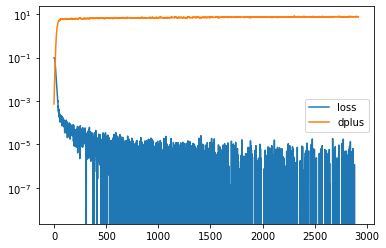

In [21]:
plt.plot(losses, label='loss')
plt.plot(dplus, label='dplus')
plt.yscale('log')
plt.legend()

In [22]:
np.mean(losses[-50:]), np.median(losses[-50:])

(3.5297958902447136e-08, 0.0)

In [25]:
features = learner.decoder(ctx['obs'])

In [26]:
f = features.detach().cpu().numpy()

In [27]:
f.shape

(5004, 25)

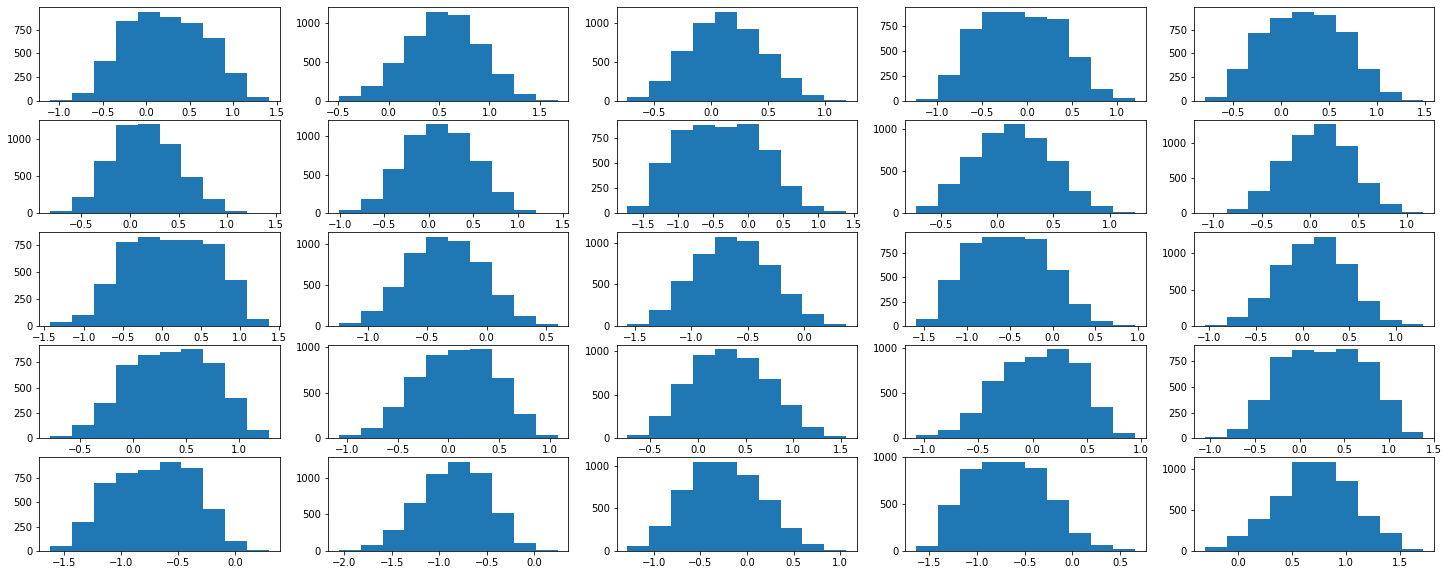

In [30]:
plt.figure(figsize=(25, 10))
for i_f in range(f.shape[1]):
    plt.subplot(5, 5, i_f + 1)
    plt.hist(f[:, i_f])

<AxesSubplot:>

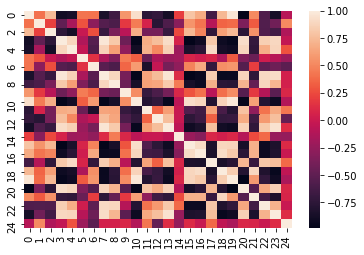

In [33]:
sns.heatmap(pd.DataFrame(f).corr())

In [34]:
ctx['obs']

tensor([[-1.0000,  0.9980, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.9980, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.9980, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        ...,
        [-1.0000,  0.9980, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.9980, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
       device='cuda:0')